In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))\

import numpy as np
import pandas as pd
import GPy
try:
    from google.colab import files
    uploaded = files.upload()
except ImportError:
    pass
    
from matplotlib import pyplot as plt
from sklearn.preprocessing import scale
    
%matplotlib inline

In [2]:
df=pd.read_csv('bitcoin_start-240418.csv')

In [3]:
df=df[:-2]
df["Dataindex"] = df.index                        ## Keep index, could be usefull
df.index=df.Date    
df.index=df.index.to_datetime()
df=df.drop(columns=['Date'])

 /m/home/home4/47/valentt1/unix/Envs/GaussianProcesses/lib/python3.5/site-packages/ipykernel_launcher.py:4: FutureWarning:to_datetime is deprecated. Use pd.to_datetime(...)


In [5]:
#take log scale
df['Close Price']=np.log(df['Close Price'])

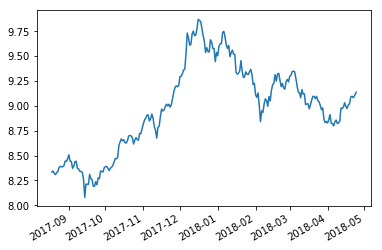

In [40]:
df['Close Price'][-250:].plot()

In [23]:
week_avg=df.groupby([df.index.weekday]).mean()

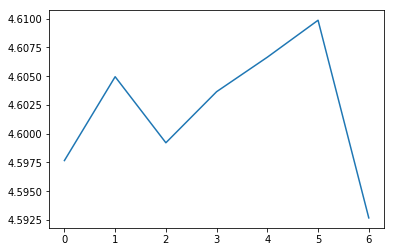

In [24]:
week_avg['Close Price'].plot()

### Data of one year

In [46]:
## PREPROCESSING

df["Weekday"] = df.index.weekday                 ## 0 = Monday, 6 = Sunday

Y = np.array(df["Close Price"][-365:]).reshape(-1, 1)

X = np.array(df["Dataindex"][-365:]).reshape(-1, 1)

train_per=0.8
split_ind=int(len(X)*train_per)
X_train=X[:split_ind]
Y_train=Y[:split_ind]
X_test=X[split_ind:]
Y_test=Y[split_ind:]

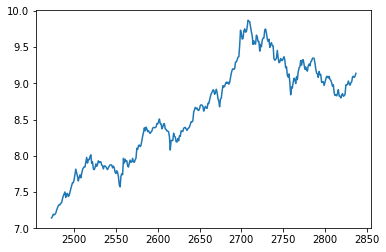

In [47]:
plt.plot(X,Y)

## NOTES

#### Possible problems
* GP Assumes that the observations come from Gaussian process, do we satisfy this?
    * * "The assumption that our observations came from a Gaussian process is a very strong assumption" https://blog.sigopt.com/posts/intuition-behind-gaussian-processes
* The toy dataset did not work, with periodic kernel :s

#### Approaches
* Data by weekday
* ~~Two dimensional. Weekday + weeknumber?~~
    * * Periodic kernel defined only for 1dim
    
    
#### Meeting with Michael
* Fourier transform
* log-transform data
* non-stationary kernels
* Brownian motion kernel
* Make some more complicated toy data with linear/RBF trend. Do experiments with data with and without periodicity. See if variance of periodic kernel is different
    *  goal is to show if modeling periodicity like this even makes sense

In [120]:
#Tinka's cool stuff
# http://www.cs.toronto.edu/~duvenaud/cookbook/                                                            Affects of addition and multiplication of kernels
# http://nbviewer.jupyter.org/github/SheffieldML/notebook/blob/master/GPy/basic_kernels.ipynb              Lecture link: Kernel overview
# http://nbviewer.jupyter.org/github/SheffieldML/notebook/blob/master/GPy/basic_gp.ipynb                   Lecture link: GP Regression tutorial

RBF = GPy.kern.RBF(input_dim=1)
RBF2 = GPy.kern.RBF(input_dim=1, variance=20000., lengthscale=20.)
PERIODIC = GPy.kern.PeriodicMatern52(input_dim=1,period=7)
PERIODIC2 = GPy.kern.PeriodicMatern52(input_dim=1,period=20)#when larger period, error: non-positive diagonal elements
EXP_PER = GPy.kern.PeriodicExponential(input_dim=1,period=7)
EXP_PER.period.fix() #if you don' t keep this fixed, it finds a period of 5.3
LIN = GPy.kern.Linear(1)
LIN2 = GPy.kern.Linear(1,variances=1000)
BIAS = GPy.kern.Bias(input_dim=1, variance=2)
BIAS2 = GPy.kern.Bias(input_dim=1, variance=35)
BIAS3 = GPy.kern.Bias(input_dim=1, variance=35)
LIN_BIAS = GPy.kern.Bias(input_dim=1, variance=350000)
EXP = GPy.kern.Exponential(1)
RQ=GPy.kern.RatQuad(1)
RQ2=GPy.kern.RatQuad(1)

RBF_PER = LIN#+BIAS + EXP_PER
LIN_BIAS = LIN + LIN_BIAS
RBF_BIAS = RBF2 + BIAS2
EXP = EXP + LIN + BIAS3



 /m/home/home4/47/valentt1/unix/Envs/GaussianProcesses/lib/python3.5/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


GP_regression.,value,constraints,priors
linear.variances,1.0523827994731549e-05,+ve,
Gaussian_noise.variance,0.21481512099174227,+ve,


(array([[1.45981184]]), array([[0.21483683]]))


 /m/home/home4/47/valentt1/unix/Envs/GaussianProcesses/lib/python3.5/site-packages/matplotlib/figure.py:2267: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


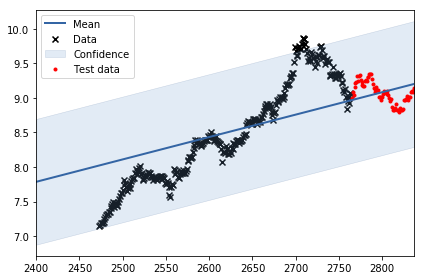

In [67]:
m = GPy.models.GPRegression(X_train, Y_train, LIN)
m.optimize()
display(m)

m.plot()
plt.scatter(X_test,Y_test,c='r',marker='.',label='Test data')
plt.legend()

print(m.predict(np.array([450]).reshape(-1, 1)))

GP_regression.,value,constraints,priors
rbf.variance,33.58236504623726,+ve,
rbf.lengthscale,15.569851016098673,+ve,
Gaussian_noise.variance,0.0029948477902645453,+ve,


(array([[0.]]), array([[33.58535989]]))


 /m/home/home4/47/valentt1/unix/Envs/GaussianProcesses/lib/python3.5/site-packages/matplotlib/figure.py:2267: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


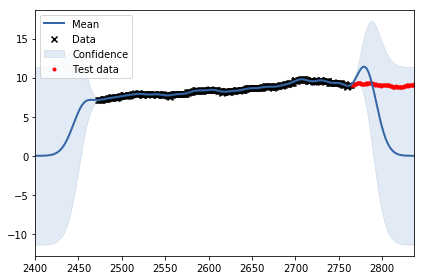

In [68]:
m = GPy.models.GPRegression(X_train, Y_train, RBF)
m.optimize()
display(m)

m.plot()
plt.scatter(X_test,Y_test,c='r',marker='.',label='Test data')
plt.legend()

print(m.predict(np.array([450]).reshape(-1, 1)))

GP_regression.,value,constraints,priors
sum.rbf.variance,0.32292740526236,+ve,
sum.rbf.lengthscale,8.915310034974677,+ve,
sum.bias.variance,71.84334869936589,+ve,
Gaussian_noise.variance,0.0023995208642122725,+ve,


(array([[8.47136966]]), array([[0.3482788]]))


 /m/home/home4/47/valentt1/unix/Envs/GaussianProcesses/lib/python3.5/site-packages/matplotlib/figure.py:2267: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


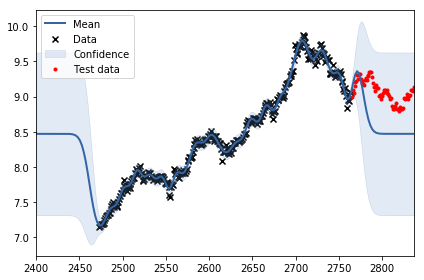

In [69]:
RBF_PER = RBF+BIAS
m = GPy.models.GPRegression(X_train, Y_train, RBF_PER)
m.optimize()
display(m)

m.plot()
plt.scatter(X_test,Y_test,c='r',marker='.',label='Test data')
plt.legend()

print(m.predict(np.array([450]).reshape(-1, 1)))

GP_regression.,value,constraints,priors
sum.rbf.variance,0.04008975320687565,+ve,
sum.rbf.lengthscale,4.24024291526383,+ve,
sum.bias.variance,145.03633708904232,+ve,
sum.linear.variances,6.127053957643209e-05,+ve,
Gaussian_noise.variance,0.0014206359830339023,+ve,


(array([[-8.47297331]]), array([[0.91870246]]))


 /m/home/home4/47/valentt1/unix/Envs/GaussianProcesses/lib/python3.5/site-packages/matplotlib/figure.py:2267: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


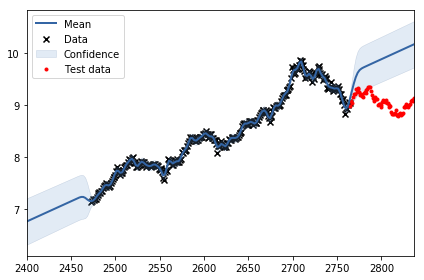

In [70]:
RBF_PER = RBF+BIAS+LIN
m = GPy.models.GPRegression(X_train, Y_train, RBF_PER)
m.optimize()
display(m)

m.plot()
plt.scatter(X_test,Y_test,c='r',marker='.',label='Test data')
plt.legend()

print(m.predict(np.array([450]).reshape(-1, 1)))

GP_regression.,value,constraints,priors
RatQuad.variance,71.93359507121978,+ve,
RatQuad.lengthscale,2.92294013522942,+ve,
RatQuad.power,0.00022041180423966792,+ve,
Gaussian_noise.variance,0.0010512010095864006,+ve,


(array([[8.33616919]]), array([[0.30407932]]))


 /m/home/home4/47/valentt1/unix/Envs/GaussianProcesses/lib/python3.5/site-packages/matplotlib/figure.py:2267: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


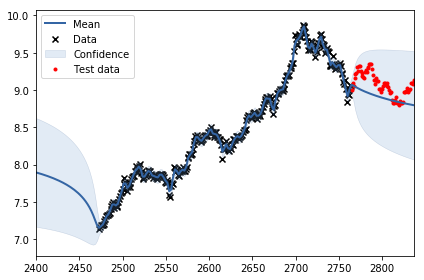

In [106]:
m = GPy.models.GPRegression(X_train, Y_train, RQ)
m.optimize()
display(m)

m.plot()
plt.scatter(X_test,Y_test,c='r',marker='.',label='Test data')
plt.legend()

print(m.predict(np.array([450]).reshape(-1, 1)))

### All data, same tests as above

In [123]:
## PREPROCESSING

df["Weekday"] = df.index.weekday                 ## 0 = Monday, 6 = Sunday

Y = np.array(df["Close Price"]).reshape(-1, 1)

X = np.array(df["Dataindex"]).reshape(-1, 1)

train_per=0.8
split_ind=int(len(X)*train_per)
X_train=X[:split_ind]
Y_train=Y[:split_ind]
X_test=X[split_ind:]
Y_test=Y[split_ind:]

GP_regression.,value,constraints,priors
linear.variances,1.1503712117879787e-05,+ve,
Gaussian_noise.variance,1.4535497177257604,+ve,


(array([[1.52625687]]), array([[1.45362526]]))


 /m/home/home4/47/valentt1/unix/Envs/GaussianProcesses/lib/python3.5/site-packages/matplotlib/figure.py:2267: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


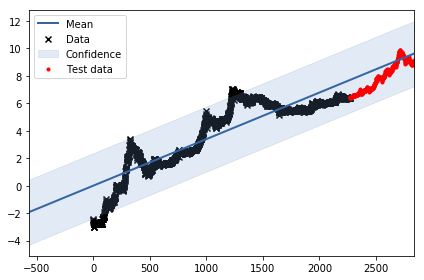

In [125]:
m = GPy.models.GPRegression(X_train, Y_train, LIN)
m.optimize()
display(m)

m.plot()
plt.scatter(X_test,Y_test,c='r',marker='.',label='Test data')
plt.legend()

print(m.predict(np.array([450]).reshape(-1, 1)))

GP_regression.,value,constraints,priors
rbf.variance,8.818079163198147,+ve,
rbf.lengthscale,12.307683192555354,+ve,
Gaussian_noise.variance,0.003214822412012793,+ve,


(array([[1.41355232]]), array([[0.00360957]]))


 /m/home/home4/47/valentt1/unix/Envs/GaussianProcesses/lib/python3.5/site-packages/matplotlib/figure.py:2267: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


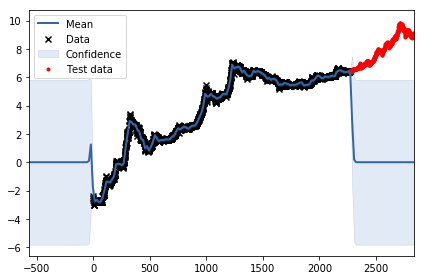

In [126]:
m = GPy.models.GPRegression(X_train, Y_train, RBF)
m.optimize()
display(m)

m.plot()
plt.scatter(X_test,Y_test,c='r',marker='.',label='Test data')
plt.legend()

print(m.predict(np.array([450]).reshape(-1, 1)))

GP_regression.,value,constraints,priors
sum.rbf.variance,3.168631931364024,+ve,
sum.rbf.lengthscale,11.320228744862842,+ve,
sum.bias.variance,14.052587247939801,+ve,
Gaussian_noise.variance,0.0031279804921154255,+ve,


(array([[1.41633462]]), array([[0.00352489]]))


 /m/home/home4/47/valentt1/unix/Envs/GaussianProcesses/lib/python3.5/site-packages/matplotlib/figure.py:2267: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


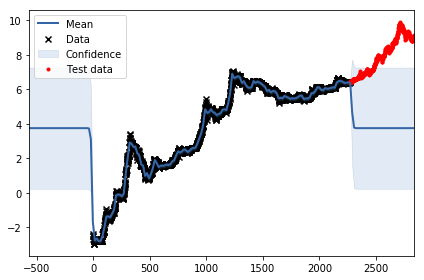

In [127]:
RBF_PER = RBF+BIAS
m = GPy.models.GPRegression(X_train, Y_train, RBF_PER)
m.optimize()
display(m)

m.plot()
plt.scatter(X_test,Y_test,c='r',marker='.',label='Test data')
plt.legend()

print(m.predict(np.array([450]).reshape(-1, 1)))

GP_regression.,value,constraints,priors
sum.rbf.variance,0.6991483402202332,+ve,
sum.rbf.lengthscale,8.247215523598273,+ve,
sum.bias.variance,0.09521621954851328,+ve,
sum.linear.variances,1.2736635039382179e-05,+ve,
Gaussian_noise.variance,0.002567161592427858,+ve,


(array([[1.42203778]]), array([[0.0029765]]))


 /m/home/home4/47/valentt1/unix/Envs/GaussianProcesses/lib/python3.5/site-packages/matplotlib/figure.py:2267: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


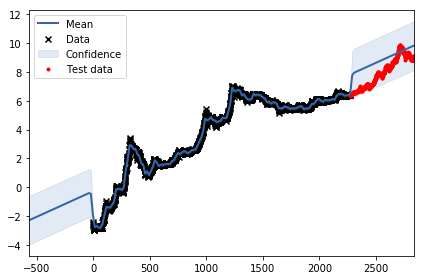

In [128]:
RBF_PER = RBF+BIAS+LIN
m = GPy.models.GPRegression(X_train, Y_train, RBF_PER)
m.optimize()
display(m)

m.plot()
plt.scatter(X_test,Y_test,c='r',marker='.',label='Test data')
plt.legend()

print(m.predict(np.array([450]).reshape(-1, 1)))

GP_regression.,value,constraints,priors
RatQuad.variance,59.058210755656255,+ve,
RatQuad.lengthscale,3.9166612378203958,+ve,
RatQuad.power,0.0006257672539028429,+ve,
Gaussian_noise.variance,0.0015444320614922632,+ve,


(array([[1.39877973]]), array([[0.00200046]]))


 /m/home/home4/47/valentt1/unix/Envs/GaussianProcesses/lib/python3.5/site-packages/matplotlib/figure.py:2267: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


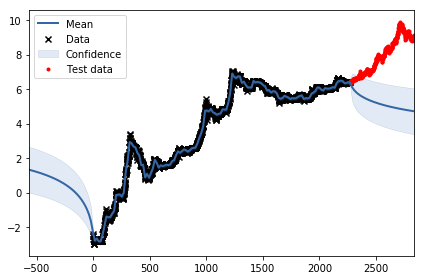

In [130]:
m = GPy.models.GPRegression(X_train, Y_train, RQ)
m.optimize()
display(m)

m.plot()
plt.scatter(X_test,Y_test,c='r',marker='.',label='Test data')
plt.legend()

print(m.predict(np.array([450]).reshape(-1, 1)))